<a href="https://colab.research.google.com/github/Wendy-syy/Projects/blob/main/MSFT_Stock_Price_Forecast.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **MSFT Stock Price Forecast**

Based on the dataset about Microsoft stock price from 04/01/2015 to 03/31/2021, establish ARMA and ARIMA models and forcast the price trend in the coming future.

P.S. the prediction of stock price normally shows a certain trend during a short period, but it is much more difficult to do so in a long time.

# Part 0: Setup Google Drive Environment

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import math
from sklearn.metrics import mean_squared_error
from pylab import rcParams
from plotly import tools
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
link = 'https://drive.google.com/open?id=1wdf3FfKdR_xNh2rJeYWL4ye0_FUZ9WM7'


fluff, id = link.split('=')
file = drive.CreateFile({'id':id}) 
file.GetContentFile('MSFT_Stock.csv') 
Price_df = pd.read_csv('MSFT_Stock.csv', index_col='Date', parse_dates=['Date'])
Price_df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2015-04-01 16:00:00,40.60,40.76,40.31,40.72,36865322
2015-04-02 16:00:00,40.66,40.74,40.12,40.29,37487476
2015-04-06 16:00:00,40.34,41.78,40.18,41.55,39223692
2015-04-07 16:00:00,41.61,41.91,41.31,41.53,28809375
2015-04-08 16:00:00,41.48,41.69,41.04,41.42,24753438


# Part 1: Data Exploration

# 1.1 Understand the Raw Dataset

In [ ]:
Price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1511 entries, 2015-04-01 16:00:00 to 2021-03-31 16:00:00
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    1511 non-null   float64
 1   High    1511 non-null   float64
 2   Low     1511 non-null   float64
 3   Close   1511 non-null   float64
 4   Volume  1511 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 70.8 KB


In [ ]:
Price_df.nunique()

Open      1409
High      1400
Low       1397
Close     1398
Volume    1511
dtype: int64

In [ ]:
Price_df.isnull().sum()

Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

# 1.2 EDA

In [ ]:
Price_df.describe()

,Open,High,Low,Close,Volume
count,1511.000000,1511.000000,1511.000000,1511.000000,1.511000e+03
mean,107.385976,108.437472,106.294533,107.422091,3.019863e+07
std,56.691333,57.382276,55.977155,56.702299,1.425266e+07
min,40.340000,40.740000,39.720000,40.290000,1.016120e+05
25%,57.860000,58.060000,57.420000,57.855000,2.136213e+07
50%,93.990000,95.100000,92.920000,93.860000,2.662962e+07
75%,139.440000,140.325000,137.825000,138.965000,3.431962e+07
max,245.030000,246.130000,242.920000,244.990000,1.352271e+08


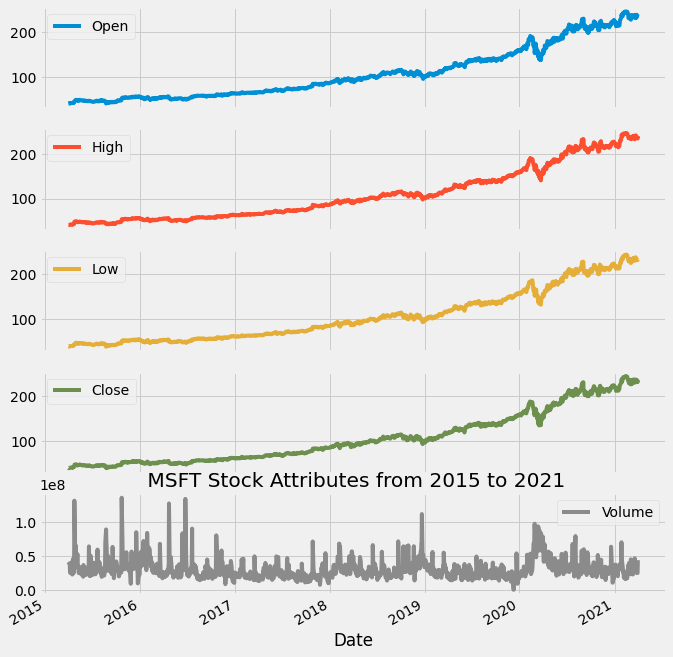

In [ ]:
Price_df['2015':'2021'].plot(subplots=True, figsize=(10, 12))
plt.title(' MSFT Stock Attributes from 2015 to 2021')
plt.show()

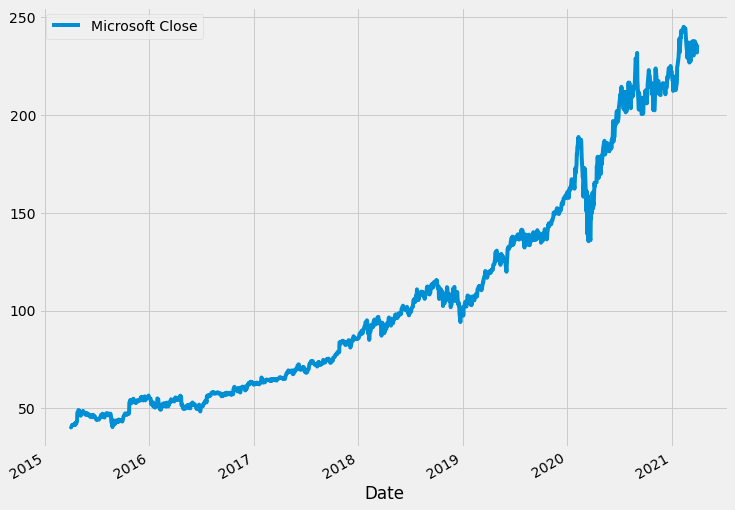

In [ ]:
Price_df.Close.plot()
plt.legend(['Microsoft Close'])

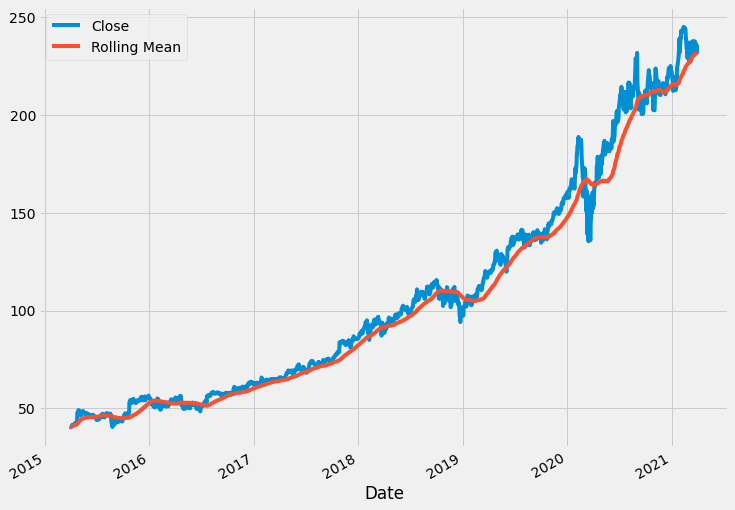

In [ ]:
# rolling mean for trend
rolling_MSFT = Price_df.Close.rolling('90d').mean()
Price_df.Close.plot()
rolling_MSFT.plot()
plt.legend(['Close', 'Rolling Mean'])

# Part 2: Data Cleaning and Feature Analysis

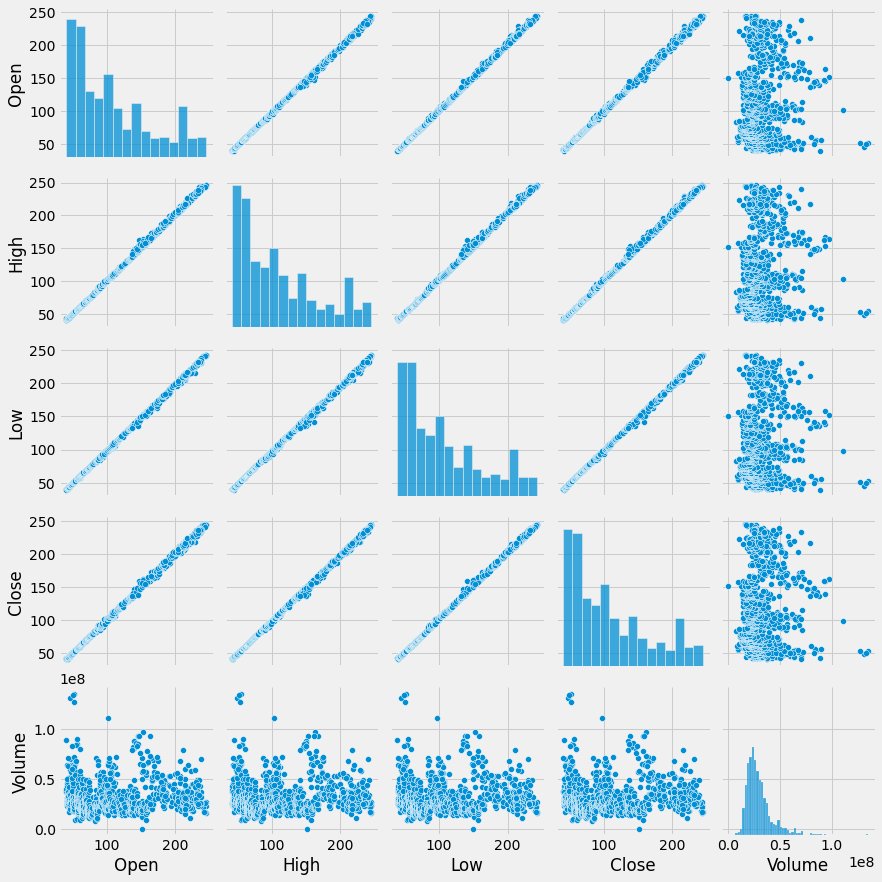

In [ ]:
import seaborn as sns
sns.pairplot(data=Price_df)

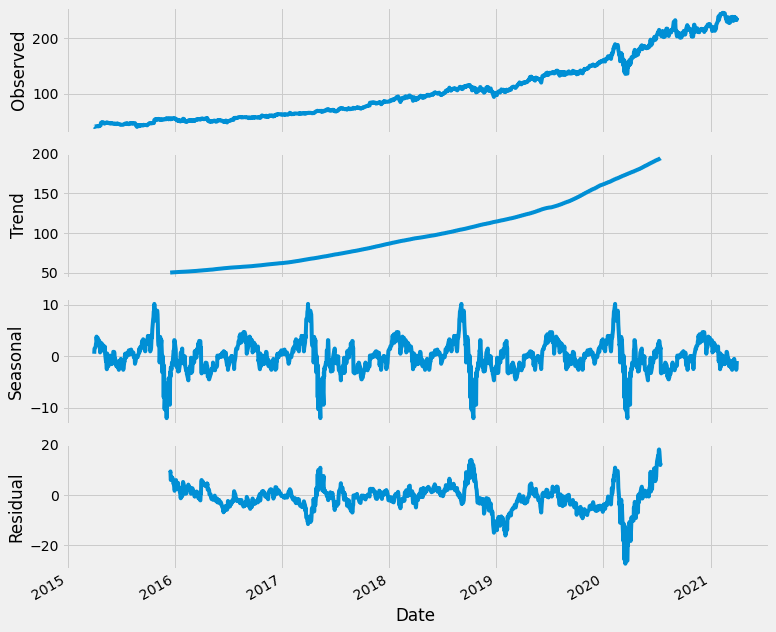

In [ ]:
rcParams['figure.figsize'] = 11, 9
Price_df_sim1_new = sm.tsa.seasonal_decompose(Price_df[['Close']],model='additive',freq=360) # The frequncy is annual
Price_df_sim2_full = Price_df[['Close']]
fig = Price_df_sim1_new.plot()
plt.show()

In [ ]:
sim1 = Price_df_sim1_new.resid.dropna()
sim2 = Price_df_sim2_full.dropna()

In [ ]:
sim1 = sim1.iloc[:,0]

In [ ]:
# ADF for stationarity test
ADFresult = adfuller(sim1)
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: -5.493650
p-value: 0.000002
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


# Part 3: Prediction and Model Evaluation

# 3.1 Prediction with ASMR

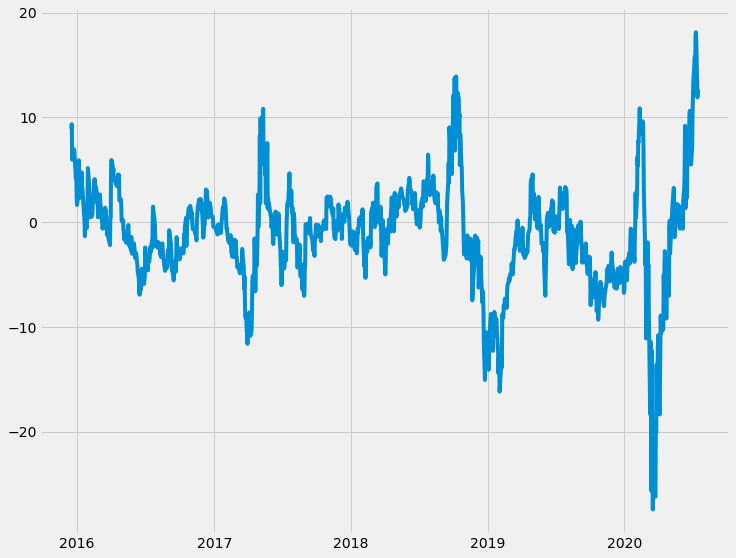

In [ ]:
plt.plot(sim1)

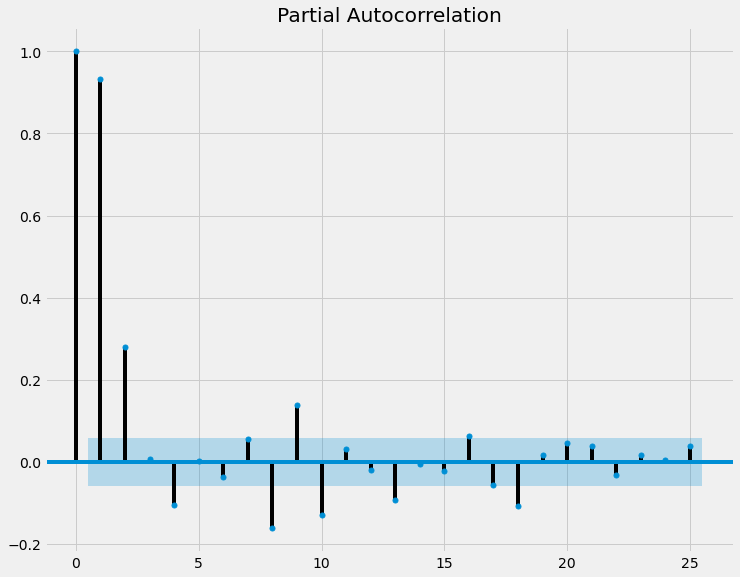

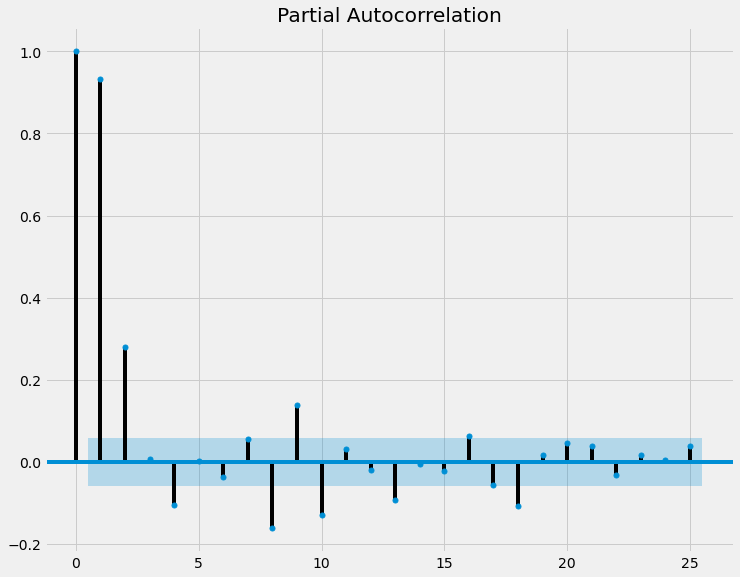

In [ ]:
plot_pacf(sim1, lags=25)

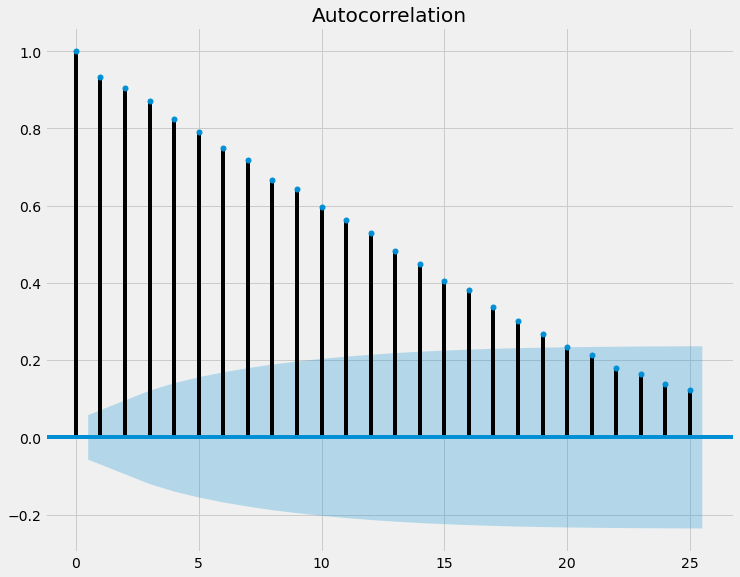

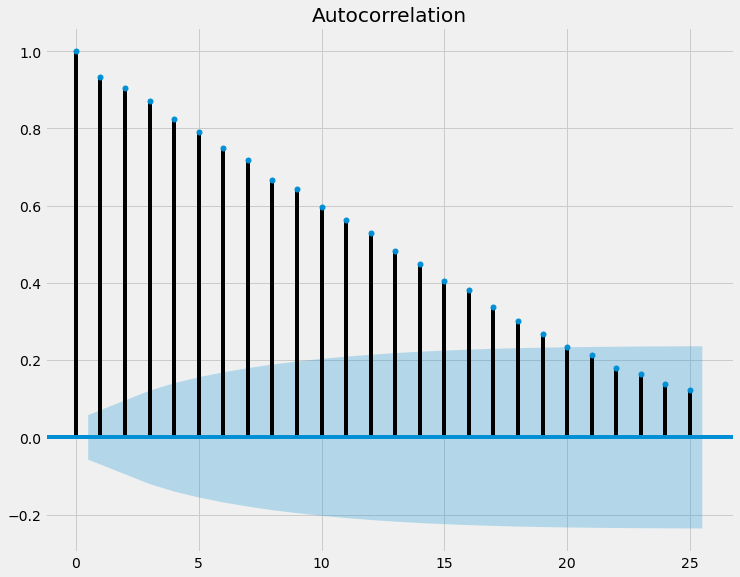

In [ ]:
plot_acf(sim1, lags=25)

In [ ]:
model = ARMA(sim1, order=(2, 0))
result = model.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.



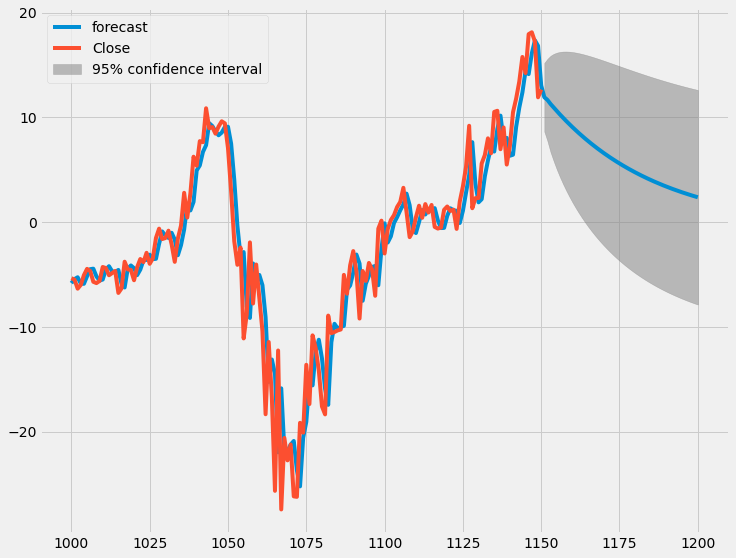

In [ ]:
result.plot_predict(1000,1200)
plt.show()

In [ ]:
resi_forecasted = result.predict(start=1000,dynamic=False)
resi_truth = sim1[-151:]
mse = ((resi_forecasted - resi_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 9.43


## 3.2 Prediction with ASIMA

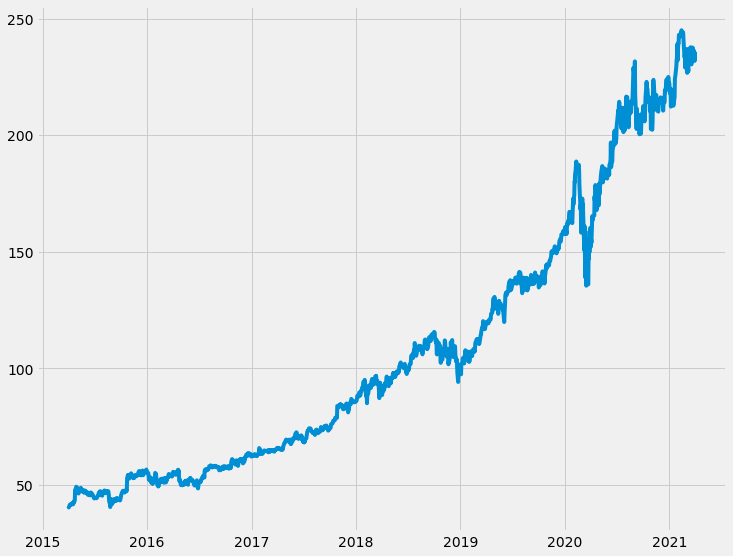

In [ ]:
plt.plot(sim2)
plt.show()

In [ ]:
sim2 = sim2.iloc[:,0]

In [ ]:
# ADF for stationarity test
ADFresult = adfuller(sim2)
print('ADF Statistic: %f' % ADFresult[0])
print('p-value: %f' % ADFresult[1])
print('Critical Values:')
for key, value in ADFresult[4].items():
  print('\t%s: %.3f' % (key, value))

ADF Statistic: 1.737136
p-value: 0.998216
Critical Values:
	1%: -3.435
	5%: -2.863
	10%: -2.568


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/statespace/sarimax.py:961: UserWarning:

Non-invertible starting MA parameters found. Using zeros as starting parameters.



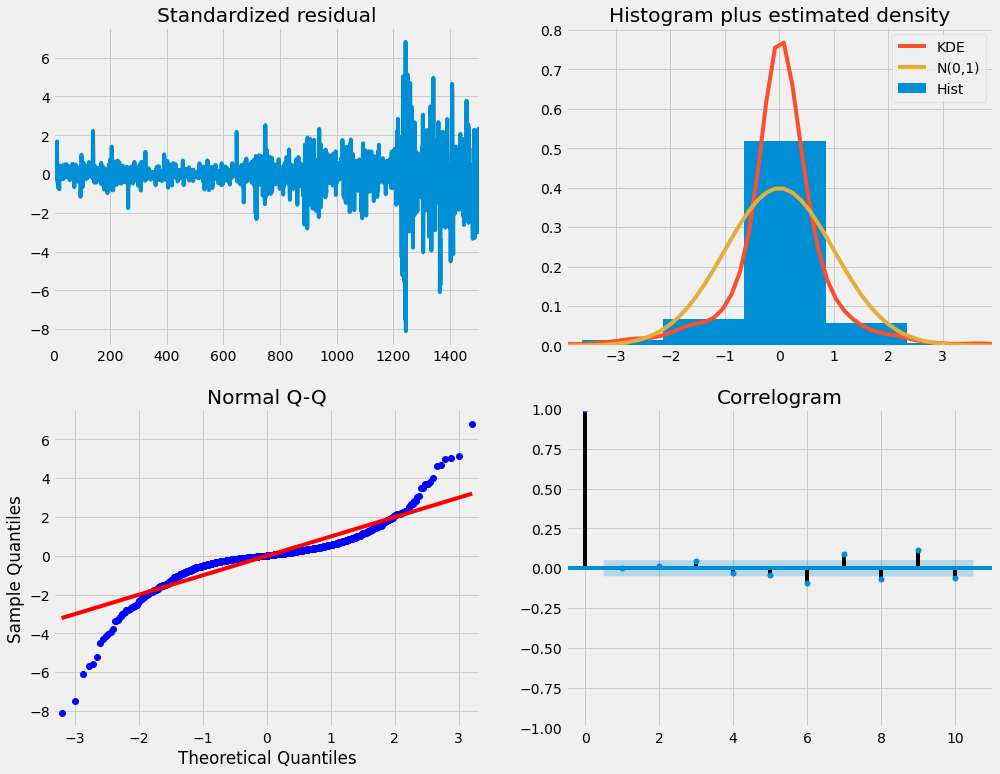

In [ ]:
mod = sm.tsa.statespace.SARIMAX(sim2, order=(2,3,2))
MSFTResults = mod.fit()
MSFTResults.plot_diagnostics(figsize=(15,12))
plt.show()

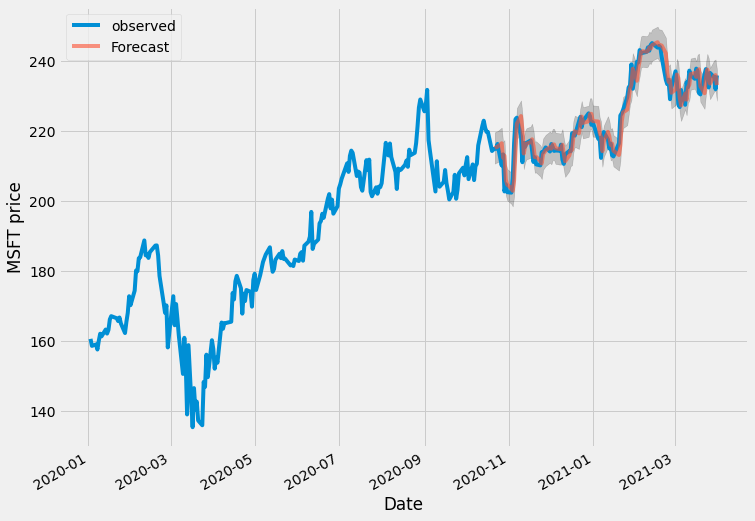

In [ ]:
pred = MSFTResults.get_prediction(start=1400, dynamic=False)
pred_ci = pred.conf_int()
ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()
plt.show()

In [ ]:
pred_ci

,lower Close,upper Close
Date,,
2020-10-21 16:00:00,210.610165,219.511894
2020-10-22 16:00:00,210.865280,219.767002
2020-10-23 16:00:00,210.968332,219.870048
2020-10-26 16:00:00,211.969891,220.871601
2020-10-27 16:00:00,207.842938,216.744641
...,...,...
2021-03-25 16:00:00,231.864426,240.765618
2021-03-26 16:00:00,228.985887,237.887078
2021-03-29 16:00:00,231.155454,240.056643


In [ ]:
price_forecasted = pred.predicted_mean
price_truth = sim2['2020-10-21 16:00:00':]
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 12.82


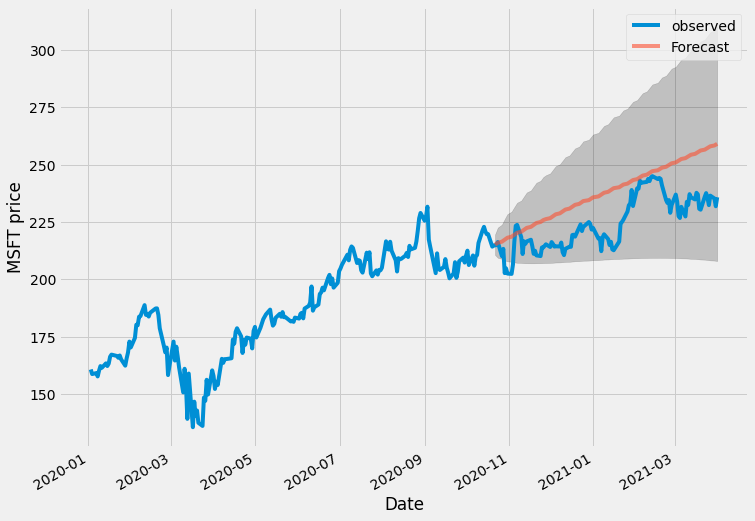

In [ ]:
pred = MSFTResults.get_prediction(start=1400, dynamic=True)
pred_ci = pred.conf_int()
ax = sim2['2020':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.6)
ax.fill_between(pred_ci.index, pred_ci.iloc[:,0], pred_ci.iloc[:,1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('MSFT price')
plt.legend()
plt.show()

In [ ]:
price_forecasted = pred.predicted_mean
price_truth = sim2['2020-10-21 16:00:00':]
mse = ((price_forecasted - price_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 234.58


# Part 4: Summary

This project selects the close as the prediction object, and finds that the dataset has an obvious upward trend during the previous exploratory data analysis. After the separation of trend and seanality, the remaining data show significant stationarity (passed ADF Test), indicating that ASMR Model is valid and applicable.The unprocessed data is not stationary, but the trend is obvious, so ARIMA Model is a better chioce.

Compared the MSE of models above, ASMR Model performs better as it does not reach the standard of practical application. 